In [1]:
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# Import rasterio
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pathlib

In [2]:
#uploading bundary file forclipping raster

folder = 'E:\GeospatialDataEssentials\GeospatialDataEssentials\exercise\data'
file_name = 'berlin.gpkg'
vector_file = folder + '/' + file_name

boundary = gpd.read_file(vector_file, layer='boundary')

In [48]:
# Define the raster file path
folder = 'E:\GeospatialDataEssentials\GeospatialDataEssentials\exercise\data'
file_name = '2023_ndwi.tif'
raster_file = folder + '/' + file_name
# Read the raster file
with rasterio.open(raster_file) as src:
# Read the raster data
    raster_data = src.read(1)
# Read additional information
    # profile = src.profile
    # bounds = src.bounds
    # resolution = src.res
    # mean_val = raster_data.mean()
    # min_val = raster_data.min()
    # max_val = raster_data.max()

In [49]:
# # Open the raster file and clip
with rasterio.open(raster_file) as src:
# Clip the raster using the bounding box
    out_image, out_transform = mask(src, boundary.geometry, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
})
# Print the profile of the clipped raster
print("Profile of the clipped raster:")
for key, value in out_meta.items():
    print(f"{key}: {value}")

# Step 7: Save the clipped raster
with rasterio.open('clipped_raster.tif', 'w', **out_meta) as dest:
    dest.write(out_image)

Profile of the clipped raster:
driver: GTiff
dtype: float32
nodata: None
width: 7491
height: 3756
count: 1
crs: EPSG:4326
transform: | 0.00, 0.00, 13.09|
| 0.00,-0.00, 52.68|
| 0.00, 0.00, 1.00|


In [50]:


# Open the raster file and read the data
# Path to your clipped raster file
clipped_raster_file = 'clipped_raster.tif'
# Open the raster file and read the data
with rasterio.open(clipped_raster_file) as src:
    raster_data = src.read(1)
    transform = src.transform
    rows, cols = raster_data.shape
# Create lists to hold point geometries and cell values
points = []
values = []
# Loop through the raster data
for row in range(0, rows, 10): # Adjust the step size as needed
    for col in range(0, cols, 10): # Adjust the step size as needed
        value = raster_data[row, col]
        if value > 0: # Only add non-NaN and non-zero values
# Get the (x, y) coordinates for the cell
            x, y = rasterio.transform.xy(transform, row, col)
            points.append(Point(x, y))
            values.append(value)

,temperature,geometry
0,0.070336,POINT (13.30661 52.65758)
1,0.073518,POINT (13.49705 52.64860)
2,0.003519,POINT (13.46381 52.64770)
3,0.063480,POINT (13.45483 52.64231)
4,0.094310,POINT (13.45573 52.64231)


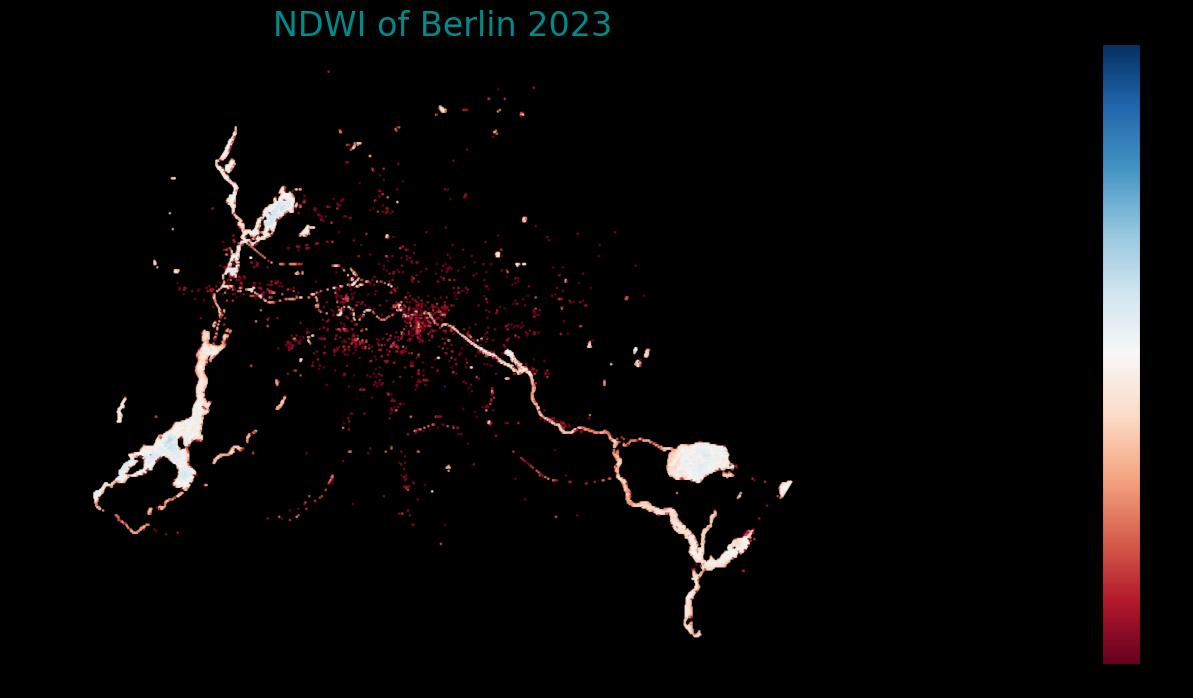

In [51]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame({'temperature': values, 'geometry': points})
# Use the original CRS of the raster data
gdf.crs = src.crs

# Print the size of the GeoDataFrame
# print(len(gdf))
# Display the GeoDataFrame
display(gdf.head())

# Normalize the population values for better visualization
norm = LogNorm(vmin=gdf['temperature'].min(), vmax=gdf['temperature'].max())

# Classifying the temperature into categories
bins = [0, 10, 15,20,25,30,35,40,62]  # You can modify the bin ranges as per your data
labels = [1,2,3,4,5,6,7,8]

gdf['temp'] = pd.cut(gdf['temperature'], bins=bins, labels=labels)

# Plot the GeoDataFrame
f, ax = plt.subplots(1, 1, figsize=(14,8))
cax = gdf.plot(column='temperature', ax=ax, cmap='RdBu', markersize=1, alpha=0.7, legend=False)  #legend false to add color bar, ndvi = RdYlGn,ndwi=RdBu
# cax = gdf.plot(column='temperature', ax=ax, cmap='hot_r', markersize=1, alpha=0.7, legend=False) #ndbi =RdBu
# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.3)
# Add a colorbar with a vertical orientation
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
sm._A = []  # This is needed to avoid an error
cbar = plt.colorbar(sm, cax=cax)
# cbar.set_label('Temperature (°C)', rotation=270, labelpad=15)

f.patch.set_facecolor('black')
ax.set_facecolor('black')
# Add map title and axis labels in red color
ax.set_title('NDWI of Berlin 2023', fontsize=24,  color='darkcyan')
plt.tight_layout()
# saving the map
NOTEBOOK_PATH = pathlib.Path().resolve()
Map = NOTEBOOK_PATH / "../Map" 

figure_path = os.path.join(Map, "2023_ndwi.png")
plt.tight_layout()
plt.savefig(figure_path, dpi=300) #define the size

In [232]:
max_index = gdf['temperature'].idxmax()
max_row = gdf.loc[max_index]
max_row

temperature                                       61.531106
geometry       POINT (13.367694995689982 52.40874673810961)
temp                                                    NaN
Name: 132430, dtype: object

In [54]:
from PIL import Image

# Path to the folder where images are stored
image_folder = 'E:\GeospatialDataEssentials\GeospatialDataEssentials\exercise\Map'

# Open the images
image1 = Image.open(os.path.join(image_folder, '2023.png'))  # Adjust image name if different
image2 = Image.open(os.path.join(image_folder, '2024.png'))
image3 = Image.open(os.path.join(image_folder, 'change.png'))
# Path to save the GIF
gif_path = os.path.join(image_folder, 'output3.gif')

# Save them as a GIF with both images
image1.save(gif_path, save_all=True, append_images=[image2,image3], duration=1000, loop=0)

print(f"GIF created successfully and saved as {gif_path}")

GIF created successfully and saved as E:\GeospatialDataEssentials\GeospatialDataEssentials\exercise\Map\output3.gif


In [6]:

folder = 'E:\GeospatialDataEssentials\GeospatialDataEssentials\exercise\data'
file_name = 'berlin.gpkg'
vector_file = folder + '/' + file_name

boundary = gpd.read_file(vector_file, layer='boundary')

In [8]:
import os
import pathlib
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from shapely.geometry import Point

def process_image(vector_file, raster_file, output_folder):
    # Read the boundary
    boundary = gpd.read_file(vector_file, layer='boundary')
    
    # Clip the raster
    with rasterio.open(raster_file) as src:
        out_image, out_transform = mask(src, boundary.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
    
    # Save the clipped raster
    base_name = os.path.basename(raster_file)
    clipped_raster_file = os.path.join(output_folder, f"clipped_{base_name}")
    with rasterio.open(clipped_raster_file, 'w', **out_meta) as dest:
        dest.write(out_image)
    
    # Process the clipped raster
    with rasterio.open(clipped_raster_file) as src:
        raster_data = src.read(1)
        transform = src.transform
        rows, cols = raster_data.shape
    
    # Create points and values lists
    points = []
    values = []
    for row in range(0, rows, 10):
        for col in range(0, cols, 10):
            value = raster_data[row, col]
            if value > 0:
                x, y = rasterio.transform.xy(transform, row, col)
                points.append(Point(x, y))
                values.append(value)
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame({'temperature': values, 'geometry': points})
    gdf.crs = src.crs
    
    # Normalize and classify temperature
    norm = LogNorm(vmin=gdf['temperature'].min(), vmax=gdf['temperature'].max())
    bins = [0, 10, 15, 20, 25, 30, 35, 40, 62]
    labels = [1, 2, 3, 4, 5, 6, 7, 8]
    gdf['temp'] = pd.cut(gdf['temperature'], bins=bins, labels=labels)
    
    # Plot
    f, ax = plt.subplots(1, 1, figsize=(14, 8))
    cax = gdf.plot(column='temperature', ax=ax, cmap='RdBu', markersize=1, alpha=0.7, legend=False)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.3)
    
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
    sm._A = []
    cbar = plt.colorbar(sm, cax=cax)
    
    f.patch.set_facecolor('black')
    ax.set_facecolor('black')
    
    ax.set_title(f'NDWI of Berlin {os.path.splitext(base_name)[0]}', fontsize=24, color='darkcyan')
    plt.tight_layout()
    
    # Save the plot
    plot_file = os.path.join(output_folder, f"{os.path.splitext(base_name)[0]}_ndwi.png")
    plt.savefig(plot_file, dpi=300)
    plt.close()

def main():
    # Set up paths
    input_folder = input("Enter the path to the folder containing the images: ")
    output_folder = input("Enter the path to save the processed images and plots: ")
    # vector_file = input("Enter the path to the vector file containing the boundary: ")
    
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Process all raster files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(('.tif', '.tiff')):  # Add more extensions if needed
            raster_file = os.path.join(input_folder, filename)
            print(f"Processing {filename}...")
            process_image(vector_file, raster_file, output_folder)
            print(f"Finished processing {filename}")

if __name__ == "__main__":
    main()

Enter the path to the folder containing the images:  E:\GeospatialDataEssentials\GeospatialDataEssentials\exercise\data\data
Enter the path to save the processed images and plots:  E:\GeospatialDataEssentials\GeospatialDataEssentials\exercise\data\output


Processing LST2023.tif...
Finished processing LST2023.tif
Processing LST2024.tif...
Finished processing LST2024.tif
